In [1]:
1+1

2

In [ ]:
include("src/gravlens.jl")

In [3]:
const GC = G/C/C
m(r) = tnfw_m(200.0, 10, r, 200.0);
rho(r) = tnfw_ρ(200.0, 10, r, 200.0);
A(r) = 1./(1-2*GC*m(r)/r);
function calc_tr_un(r)
    a,b = quadgk(r->sqrt(A(r))/r,200.0,r, reltol=1e-27, abstol=1.0e-27)
    exp(a)
end
function calc_tr_sch(r)
    sr = sqrt(r)
    (0.5*(sr+sqrt(r-4*(GC*200.0/2))))^2
end
const r_fac = calc_tr_sch(200.0e7)/calc_tr_un(200.0e7)
function calc_tr(r)
    r_fac.*calc_tr_un(r)
end
b_integrand(r) = -2*GC/r/r*(m(r)+0.0)*A(r);
B(r) = exp(-quadgk(b_integrand, r, 1.0e45, reltol=1e-27, abstol=1e-27)[1]);

In [4]:
r = collect(10.^linspace(log10(0.1), log10(5.0e6), 1000));
# tr = [Float64(calc_tr(big(ri))) for ri in r];
tr = open("tr.data","r") do f
    tr = zeros(1000)
    read!(f, tr)
    tr
end;

In [5]:
const spl = Spline1D(tr, r, k=5, bc="error");
fast_r(tr) = evaluate(spl, tr);
# open("tr.data","w") do f
#     write(f, tr)
# end

fast_r (generic function with 1 method)

In [6]:
function L(r)
    const br = big(r)
    const tr = calc_tr(br)    
    const g = 1./(br.*br./tr./tr)
    const f = B(tr)
    Float64(sqrt(f./g))
end

L (generic function with 1 method)

In [7]:
r = 10.^linspace(log10(0.11), log10(4.99e6), 1000);
#_l = [L(ri) for ri in r];
_l = open("l.data","r") do f
    _l = zeros(1000)
    read!(f, _l)
    _l
end;

In [8]:
const spl_l = Spline1D(r, _l, k=5, bc="extrapolate");
fast_l(r) = evaluate(spl_l, r);
fast_dl(r) = derivative(spl_l, r);
# open("l.data","w") do f
#    write(f, _l)
# end

8000

In [31]:
fast_l(r) = 1.0+exp(-(r/100).^2)/50000;
fast_dl(r) = -r/(5000*exp((r^2)/10000))/50000;

In [9]:
L(10.0)-L(1e6)

2.9528400995459947e-6

In [10]:
fast_l(10.0)-fast_l(1e6)

2.952840099990084e-6

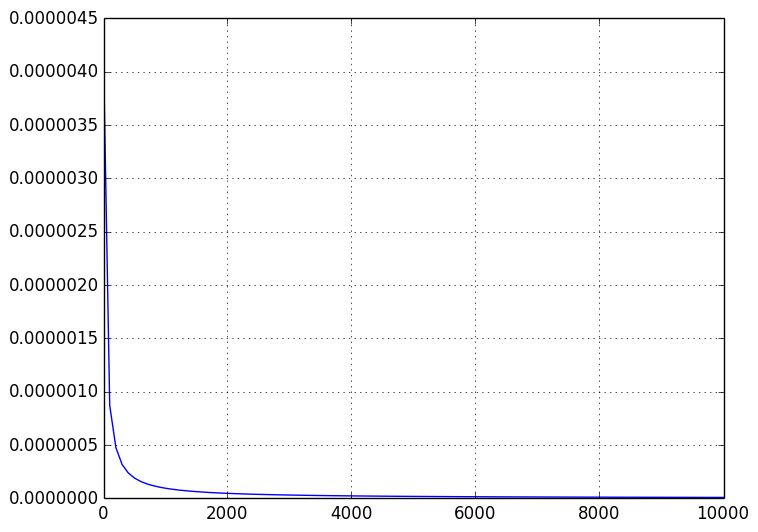

In [13]:
plot(1:100:100000, [fast_l(lxi)-1.0 for lxi in 1:100:100000])
xlim(1,10000)
grid(true)

In [14]:
function full_fermat(rs, tgα, N=100; reltol=1e-21, abstol=1e-21, ext=1.0)
    function f(x,yvec)
        (y, v) = yvec
        y_prime = v

        r = sqrt(x*x+y*y)
        eta = fast_l(r)
        deta = fast_dl(r)
        y_prime2 = y_prime*y_prime
        yp1 = y_prime2+1.0
        
        _a = eta*r*(1-y_prime2/yp1/yp1)
        _b = (y*y_prime+x)*y_prime*deta + yp1*y*deta
        
        v_prime = _b/_a
        [y_prime, v_prime]
    end
    _x = linspace(0.0,1,div(N,2)).^2
    _l = [-reverse(_x)*rs ; _x*rs.*ext]
    x, u = ode45(f, [0.0; tgα], _l; reltol=reltol, abstol=abstol)
    y = map(u -> u[1], u);
    dy = map(u -> u[2], u);    
    x,y
end


full_fermat (generic function with 2 methods)

In [17]:
rs = 1.0e6
b = 3.0
tgα = b/rs
N = 100000
x, y = full_fermat(rs, tgα, N; reltol=1e-19, abstol=1e-19);

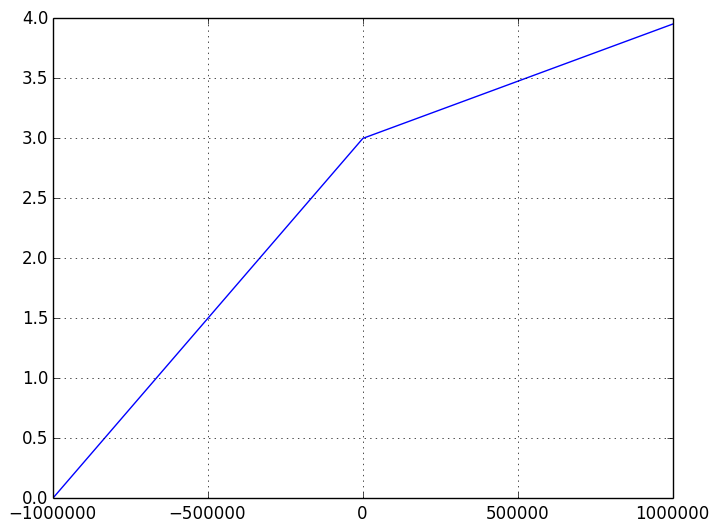

In [18]:
plot(x,y)
#xlim(-3000,3000)
#ylim(4.99,5.01)
grid(true)